<a href="https://colab.research.google.com/github/kmilonas/Dengue-fever/blob/main/Dengue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dengue fever prediction
Introduction: this notebook tries to predict cases of dengue fever from environmental variables. It is done as part of a competition organized by [Driven Data](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/).

Note: this is work in progress and the predictive accuracy has room for improvement. I discuss some potential avenues towards this end in the [Conclusion](https://colab.research.google.com/drive/1diaz4fUCRty63yT3cLteRHGHNgYQwVRB#scrollTo=OipJ2GPEITJ1&line=2&uniqifier=1).


In [203]:
import pandas as pd
import numpy as np
%matplotlib inline
#from ggplot import *
from sklearn.ensemble import RandomForestRegressor
import unittest
import seaborn as sns
import xgboost as xgb

from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/dengue"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dengue_features_test.csv   dengue_labels_train.csv
dengue_features_train.csv  submission_format.csv


In [204]:
# Read data from GDrive; alternatively from the URLs bvelow
features = pd.read_csv('/content/drive/My Drive/dengue/dengue_features_train.csv') #https://drive.google.com/file/d/1EtfbBUhjaeVPQ93NhfpcMHKnwN486YX5/view?usp=sharing
labels = pd.read_csv('/content/drive/My Drive/dengue/dengue_labels_train.csv') #https://drive.google.com/file/d/12s9ZlRnxCGjXK9qZQN6utd37KkXMy4mf/view?usp=sharing
features_testset = pd.read_csv('/content/drive/My Drive/dengue/dengue_features_test.csv') #https://drive.google.com/file/d/1G4wILHaGlHjhHh2cePF90H_VLu2VBdyA/view?usp=sharing

In [157]:
labels.describe(include = "all")

,city,year,weekofyear,total_cases
count,1456,1456.000000,1456.000000,1456.000000
unique,2,NaN,NaN,NaN
top,sj,NaN,NaN,NaN
freq,936,NaN,NaN,NaN
mean,NaN,2001.031593,26.503434,24.675137
std,NaN,5.408314,15.019437,43.596000
min,NaN,1990.000000,1.000000,0.000000
25%,NaN,1997.000000,13.750000,5.000000
50%,NaN,2002.000000,26.500000,12.000000
75%,NaN,2005.000000,39.250000,28.000000


In [158]:
# Create nicer city names and date format
labels["date"] = pd.to_datetime(labels.year.astype(str), format='%Y') + pd.to_timedelta(
    labels.weekofyear.mul(7).astype(str) + ' days')

labels['city'] = labels['city'].str.replace('sj','San Juan').str.replace('iq','Iquitos')

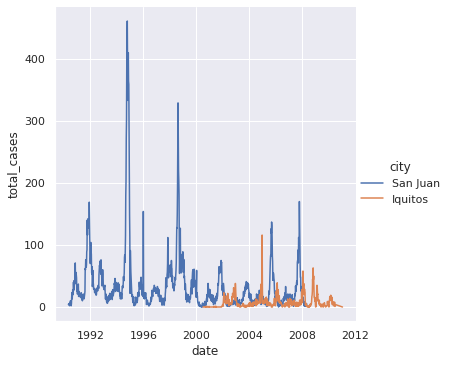

In [159]:
sns.set()
sns.relplot(x="date", y="total_cases", hue="city", kind="line",
            data=labels)

#### Observations

Little correlation across the two cities. Can therefore likely fit separate models by city.

The case count is extremely skewed.

No immediately apparent trends or seasonality.

In [160]:
def feature_engineering(features):
  features['city'] = features['city'].str.replace('sj','San Juan').str.replace('iq','Iquitos')

  # easier to have consistent measurement of temperature in Kelvin scale
  features = pd.concat([features[col] - 273.15 if (col.find("_c") != -1) else features[col] 
                            for col in features], 1)                          
  features.columns = features.columns.str.replace('_c','_k')
  features.columns = features.columns.str.replace('reanalysis_avg_temp_k','reanalysis_avg_air_temp_k') #easier to have consistent naming

  features['eng_ndvi_mean'] = features[['ndvi_se', 'ndvi_sw', 'ndvi_ne', 'ndvi_ne']].mean(axis=1)
  features['eng_ndvi_max'] = features[['ndvi_se', 'ndvi_sw', 'ndvi_ne', 'ndvi_ne']].max(axis=1)
  features['eng_ndvi_min'] = features[['ndvi_se', 'ndvi_sw', 'ndvi_ne', 'ndvi_ne']].min(axis=1)

  features['eng_precip'] = features[['precipitation_amt_mm','reanalysis_sat_precip_amt_mm', 'reanalysis_precip_amt_kg_per_m2']].mean(axis=1)
  features['eng_diurn'] = features[['station_diur_temp_rng_k','reanalysis_tdtr_k']].mean(axis=1)

  #Notes on missing data:
  #Some missing values in all variables except time and place vars
  #Use moments of related variables (e.g. mean measurement at other corners of city when the southeast is missing)
  # repeat this over avg, min, and max. and add to the data
  eng_temps = pd.concat([ features[[''.join(['station_',x,'_temp_k']), 
                                        ''.join(['reanalysis_', x, '_air_temp_k'])]].mean(axis=1) 
 for x in ['min','max', 'avg'] ], 1)

  eng_temps.columns = [''.join(['eng_temp_',x]) for x in ['min','max', 'avg'] ]
  
  features = pd.concat([features, eng_temps], axis=1) 
  return features

In [161]:
features = feature_engineering(features)

In [25]:
# check that just one obs per date-city
obs_per_cty_date = np.unique(labels[['total_cases','city','date']].groupby(['city', 'date']).size().reset_index(name='counts')[['counts']].to_numpy())
assert obs_per_cty_date == np.array([1])

In [162]:
[features[[''.join(['station_',x,'_temp_k']), ''.join(
    ['reanalysis_', x, '_air_temp_k'])]].isna().sum() for x in ["min", "max", "avg"]]
# still some missing obs

[station_min_temp_k           14
 reanalysis_min_air_temp_k    10
 dtype: int64, station_max_temp_k           20
 reanalysis_max_air_temp_k    10
 dtype: int64, station_avg_temp_k           43
 reanalysis_avg_air_temp_k    10
 dtype: int64]

In [163]:
# create list of features to use in analysis - use only the engineered ones for now
features_cols_use = [i for i in features.columns if 'eng_' in i] 
features_cols_use.extend([i for i in features.columns if 'ndvi_' in i] )
features_cols_use.extend([i for i in features.columns if 'humidity' in i] )
features_cols_use = list(dict.fromkeys(features_cols_use)) #removing duplicates - TBA why arise
features_cols_use

['eng_ndvi_mean',
 'eng_ndvi_max',
 'eng_ndvi_min',
 'eng_precip',
 'eng_diurn',
 'eng_temp_min',
 'eng_temp_max',
 'eng_temp_avg',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'reanalysis_relative_humidity_percent',
 'reanalysis_specific_humidity_g_per_kg']

In [164]:
features_cols_use.extend(['city'])
X = features.loc[:,features_cols_use]

## Random forest
Start by a grid search over different hyperparameters to find model that best fits the data (in terms of cross-validation mean absolute error, i.e., the metric used for this competition)

In [32]:
y = labels['total_cases'].values
assert np.count_nonzero(np.isnan(train_y)) == 0 #check all y nonmissing

In [165]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.1) #choose a relatively small validation set since we already have a fairly small sample

In [166]:
categorical_features_colidx = features_cols_use.index('city')

# Impute missing values using iterative extreme RF
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

In [66]:
impute_estimator =   ExtraTreesRegressor(random_state=0,n_estimators = 30)# experimentation indicated that it doesn't get much better w higher

inner_estimator  = RandomForestRegressor(random_state = 42)

scaler = StandardScaler()

transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [categorical_features_colidx])], remainder="passthrough")
    
estimator = make_pipeline(
    transformer,
    scaler,
   IterativeImputer(random_state=0, estimator=impute_estimator),
    inner_estimator, verbose = True
)
parameters = {}
nmaxdepth = [3,4,5]
nparsRF = [200, 300, 400]
parameters['randomforestregressor__n_estimators'] = nparsRF
parameters['randomforestregressor__max_depth'] = nmaxdepth

CV = GridSearchCV(estimator, parameters, scoring = 'neg_mean_absolute_error')
CV.fit(train_x, train_y)  

[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.1s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   0.9s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.8s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   0.8s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.7s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   0.8s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.9s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   0.9s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.8s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   0.9s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.6s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.2s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.1s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.3s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.3s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.3s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.1s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.3s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  21.0s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.3s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.8s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.7s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.1s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.8s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.0s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.6s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.6s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.7s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.0s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.8s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  21.1s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.1s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.3s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.0s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.3s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.1s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.1s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.0s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.2s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.0s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.3s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.5s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.7s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.6s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.4s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.6s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.9s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.6s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.1s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.6s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.7s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   2.0s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.4s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   2.0s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.5s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   2.1s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.1s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   2.2s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.6s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   2.0s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.7s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.2s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.2s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.2s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.1s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.3s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  21.2s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.3s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.7s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.2s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.7s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.8s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.4s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.8s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.2s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.9s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.8s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.8s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.4s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.9s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.9s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   2.5s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.5s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   2.4s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.4s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   2.5s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.4s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   2.5s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.1s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   2.4s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  24.4s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.5s


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('cat',
                                                                         OneHotEncoder(categories='auto',
                                                                                       drop=None,
                                                                                       dtype=<class 'numpy.float64'>,
                                                                                       handle_unknown='error',
                        

Visualize performance over grid of hyperparameters (maximum depth and number of trees)

Text(0.5, 0, 'mean_test_score')

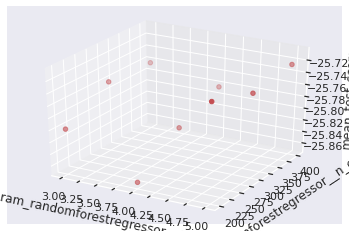

In [67]:
cvresults = pd.DataFrame(CV.cv_results_)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cvresults['param_randomforestregressor__max_depth'], cvresults['param_randomforestregressor__n_estimators'], cvresults['mean_test_score'], c='r', marker='o')
ax.set_xlabel('param_randomforestregressor__max_depth')
ax.set_ylabel('param_randomforestregressor__n_estimators')
ax.set_zlabel('mean_test_score')

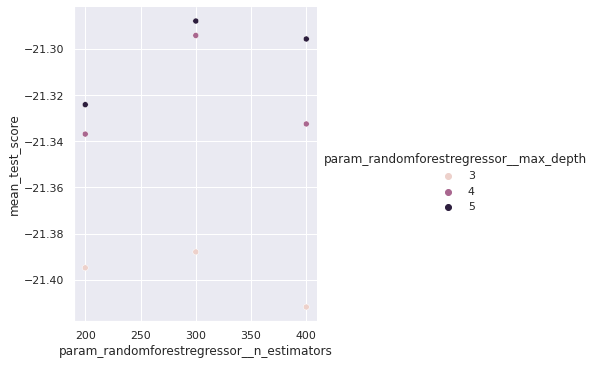

In [39]:
sns.relplot(x='param_randomforestregressor__n_estimators', y = 'mean_test_score', hue='param_randomforestregressor__max_depth', kind='scatter', data=cvresults)

In [73]:
estimator = CV.best_estimator_ # choose the best parameterization and use it for prediction after fitting to specified training data
estimator.fit(train_x,train_y)

[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.8s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.2s


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  [14])],
                                   verbose=False)),
                ('standardscaler',
                 StandardScaler(copy=True, with_me...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
    

In [72]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y,estimator.predict(val_x))

22.07566005739815

Visualize performance on the validation and training sets. Results indicate that we do somewhat well on predicting high case counts, while performance is poor for low and medium counts.

Text(0.5, 0.98, 'Test set')

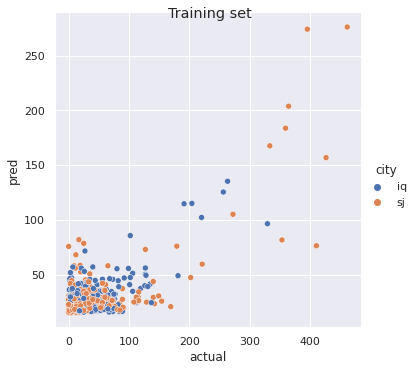

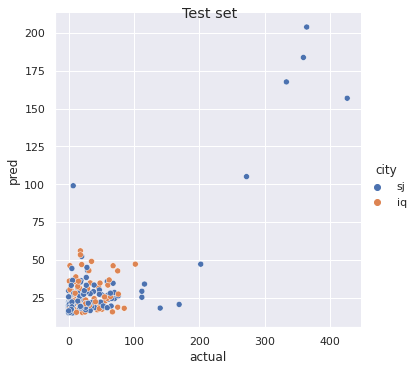

In [75]:
dataforplot_train = pd.DataFrame({'actual': train_y, 'pred': estimator.predict(train_x), 'city': train_x['city']})
ptrain = sns.relplot(x='actual', y = 'pred', hue='city', kind='scatter', data=dataforplot_train)
ptrain.fig.suptitle("Training set")

dataforplot_test = pd.DataFrame({'actual': test_y, 'pred': estimator.predict(test_x), 'city': test_x['city']})
ptest = sns.relplot(x='actual', y = 'pred', hue='city', kind='scatter', data=dataforplot_test)
ptest.fig.suptitle("Test set")

# XGBoost

In [167]:
from xgboost import XGBRegressor

def fair_obj(preds, dtrain): #approximate MAE, since that loss won't work since not everywhere differentiable. see https://stackoverflow.com/questions/45006341/xgboost-how-to-use-mae-as-objective-function
    """y = c * abs(x) - c**2 * np.log(abs(x)/c + 1)"""
    x = preds - dtrain#.get_labels()
    c = 10^-5 #smoothing parameter; manual tuning indicated that a lower value worked better for this problem
    den = abs(x) + c
    grad = c*x / den
    hess = c*c / den ** 2
    return grad, hess

inner_estimator  = XGBRegressor(objective = fair_obj) #objective=huber_approx_obj

transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [categorical_features_colidx])], remainder="passthrough")
    
estimatorXGB = make_pipeline(
    transformer,
    inner_estimator#, verbose = True
)
parameters = {}
nmaxdepth = [3,4,5,10]
nparsRF = [200, 300, 400]
parameters['xgbregressor__max_depth'] = nmaxdepth
CV_XGB = GridSearchCV(estimatorXGB, parameters, scoring = 'neg_mean_absolute_error')
CV_XGB.fit(train_x, train_y)

[00:39:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:39:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:39:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:39:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:39:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:39:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:39:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:39:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('cat',
                                                                         OneHotEncoder(categories='auto',
                                                                                       drop=None,
                                                                                       dtype=<class 'numpy.float64'>,
                                                                                       handle_unknown='error',
                        

Analyze performance. Further improvement is needed since it's currently poor on both training and validation sets.

In [168]:
  # analyse performance
estimatorXGB = CV_XGB.best_estimator_ # choose the best parameterization and use it for prediction
estimatorXGB.fit(train_x,train_y)
mean_absolute_error(val_y,estimatorXGB.predict(val_x))

[00:39:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


23.237963682780528

Text(0.5, 0.98, 'Test set; XGBoost')

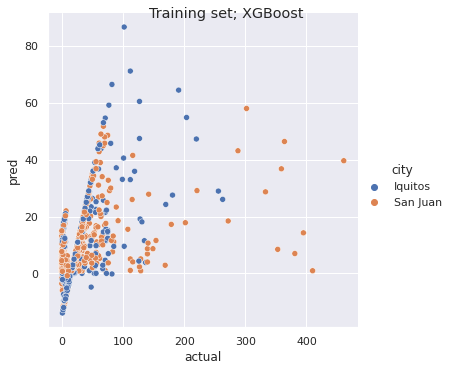

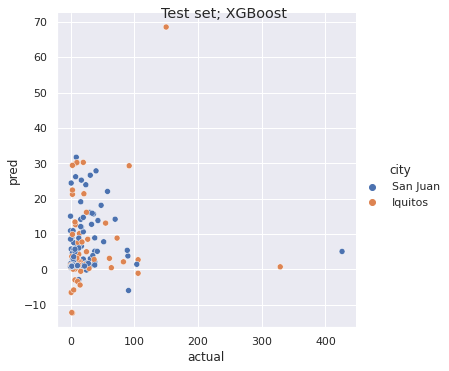

In [169]:
dataforplot_train = pd.DataFrame({'actual': train_y, 'pred': estimatorXGB.predict(train_x), 'city': train_x['city']})
ptrain = sns.relplot(x='actual', y = 'pred', hue='city', kind='scatter', data=dataforplot_train)
ptrain.fig.suptitle("Training set; XGBoost")

dataforplot_test = pd.DataFrame({'actual': val_y, 'pred': estimatorXGB.predict(val_x), 'city': val_x['city']})
ptest = sns.relplot(x='actual', y = 'pred', hue='city', kind='scatter', data=dataforplot_test)
ptest.fig.suptitle("Test set; XGBoost")

## Predict from test set and export for submission


In [205]:
# Feature engineering as on training set
# easier to have consistent measurement of temperature in Kelvin scale
features_testset = feature_engineering(features_testset)

In [206]:
Xtest = features_testset.loc[:,features_cols_use]
Xtest.loc[pd.isnull(Xtest['city']),'city'] = 'NaN'

testpred = estimatorXGB.predict(Xtest)

In [195]:
#get right submission format
predsubm = features_testset.loc[:,['city','year','weekofyear']]
predsubm['total_cases'] = np.rint(testpred).astype(int)
# abbreviate city names as in original file
predsubm['city'] = predsubm['city'].str.replace('San Juan','sj').str.replace('Iquitos','iq')
predsubm.to_csv('dengue_preds.csv', index=False)
!cp dengue_preds.csv "drive/My Drive/"

# Conclusion
The best estimator of those tested so far is:

In [118]:
'XGBoost' if mean_absolute_error(val_y,estimatorXGB.predict(val_x)) < mean_absolute_error(val_y,estimator.predict(val_x)) else 'Random Forest'

'XGBoost'

However, the estimator shows material room for improvement. This could potentially be achieved by

*   Combining these two (and other) estimators into an ensemble
*   Further hyperparameter tuning
*   Building and implementing domain knowledge, which could be particularly useful given that the sample is relatively small.

